In [1]:
from CUKG import CUKG
from DTWMV import DTWMV
from History import History
import opinion_dataset as random_dataset

from crowdkit.aggregation import DawidSkene
from crowdkit.aggregation import MajorityVote
from crowdkit.datasets import load_dataset
from crowdkit.aggregation import OneCoinDawidSkene
from crowdkit.aggregation import GLAD
from crowdkit.aggregation import KOS
from crowdkit.aggregation import MMSR
from crowdkit.aggregation import Wawa
from crowdkit.aggregation import MACE
from crowdkit.aggregation import ZeroBasedSkill

import pandas as pd
import numpy as np

import tools
import matplotlib.pyplot as plt
import pickle

In [2]:
def run_experiment(df, classifier):
    if type(classifier).__name__ == 'CUKG' or type(classifier).__name__ == 'History':
        opinions, confidence = tools.dataframe_to_opinions(df)
        aggregated_labels = classifier.run(confidence, opinions)
    elif type(classifier).__name__ == 'DTWMV':
        opinions, confidence = tools.dataframe_to_opinions(df)
        aggregated_labels = classifier.run(confidence)
    else:
        aggregated_labels = classifier.fit_predict(df)
        
    return aggregated_labels

In [3]:
def print_variables(classifiers, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,
                    confidence_worker,hard_labels,itt):
    print("classifiers: ",classifiers)
    print("prob_type_workers: ",prob_type_workers)
    print("n_tasks: ",n_tasks)
    print("n_workers: ",n_workers)
    print("percetage_tasks_workers: ",percetage_tasks_workers)
    print("prob_worker: ",prob_worker)
    print("confidence_worker: ",confidence_worker)
    print("hard_labels: ",hard_labels)
    print("itt: ",itt)
    return

In [4]:
def save_variables(save_file, classifiers, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,
                    confidence_worker,hard_labels,itt):
    with open(save_file+"baseline_variables.txt", "w") as file:
        file.write("classifiers: " + str(classifiers) + "\n")
        file.write("prob_type_workers: " + str(prob_type_workers) + "n")
        file.write("n_tasks: " + str(n_tasks) + "\n")
        file.write("n_workers: " + str(n_workers) + "\n")
        file.write("percetage_tasks_workers: " + str(percetage_tasks_workers) + "\n")
        file.write("prob_worker: " + str(prob_worker) + "\n")
        file.write("confidence_worker: " + str(confidence_worker) + "\n")
        file.write("hard_labels: " + str(hard_labels) + "\n")
        file.write("itt: " + str(itt) + "\n")
    return

In [5]:
def save_results(save_file,final_responses, final_labels, final_accuracies, final_errors):
    results = [save_file,final_responses, final_labels, final_accuracies, final_errors]
    with open(save_file+'baseline_results.pickle', 'wb') as handle:
        pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

In [6]:
#prob_worker = ([[type_worker_x0,type_worker_x1,...] , [type_worker_y0,type_worker_y1,...], ...] -> experiments x, y...
def run_experiment_random_datasets(classifiers, prob_type_workers, n_tasks=20,n_workers=5,percetage_tasks_workers=1,
                                   prob_worker=[[0.3,0.1],[0.3,0.1],[0.8,0.1],[0.8,0.1],[-1,-1],[-1,-1],[-1,-1]],
                                   confidence_worker=[[0.8,0.1],[0.3,0.1],[0.8,0.1],[0.3,0.1],[-1,0.1],[-1,-1],[0.8,0.1]],hard_labels=False, itt=30, save_file="./"):

    print_variables(classifiers, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,confidence_worker,hard_labels,itt)
    save_variables(save_file, classifiers, prob_type_workers, n_tasks,n_workers,percetage_tasks_workers,prob_worker,confidence_worker,hard_labels,itt)
    
    final_accuracies = []
    final_errors = []
    final_labels = []
    final_responses = []
    for count1, experiment in enumerate(prob_type_workers):
        accuracies = []
        errors = []
        labels = []
        responses = []
        for count2, prob_type_worker in enumerate(experiment):
            accuracy = []
            error = []
            label = []
            response = []
            for i in range(itt):
                lbls, workers_opinions, confidence_opinions, probabilities = random_dataset.generate_dataset(n_tasks,n_workers,percetage_tasks_workers,
                                                                                                               prob_type_worker,prob_worker,confidence_worker,hard_labels)
                df = tools.opinions_to_dataframe(workers_opinions, confidence_opinions, bin_lenght = -1)
                df_digitize = tools.opinions_to_dataframe(workers_opinions, confidence_opinions)
                accs = []
                errs = []
                res = []
                
                for count4, c in enumerate(classifiers):
                    if type(c).__name__ == 'CUKG' or type(c).__name__ == 'DTWMV' or type(c).__name__ == 'History':
                        r = run_experiment(df, c)
                    else:
                        r = run_experiment(df_digitize, c)
                        r = tools.reverse_digitize_features(r)
                        
                    acc = tools.calculate_accuracy(lbls, r)
                    err = tools.calculate_avg_error(lbls, r)
                    accs.append(acc)
                    errs.append(err)
                    res.append(r)
                    total = len(classifiers)*itt*len(experiment)*len(prob_type_workers)
                    percentage = ((count4 + (i*len(classifiers)) + (count2*itt*len(classifiers)) + (count1*len(experiment)*itt*len(classifiers))) / total)*100
                    print(f"\rProgress: {percentage:.2f}%", end="")
                    
                response.append(res)
                label.append(lbls)
                accuracy.append(accs)
                error.append(errs)
                
            responses.append(response)
            labels.append(label)
            accuracies.append(accuracy)
            errors.append(error)
            
        final_responses.append(responses)
        final_labels.append(labels)
        final_accuracies.append(accuracies)
        final_errors.append(errors)

    save_results(save_file,final_responses, final_labels, final_accuracies, final_errors)

    return final_responses, final_labels, final_accuracies, final_errors

In [37]:
def plot_experiment(data_points, x_label, y_label, classifiers, title="", custom_x_labels=['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%', '100%'],
                    colors=['blue', 'cyan', 'red', 'pink', 'green', 'black', 'purple', 'orange', 'yellow'], fig_name='', min_y=0, max_y=1, save_file = "./"):

    #Take average of the all iterations
    averages = np.mean(data_points, axis=1)

    #Convert classifiers to strings if this is not already the case
    if isinstance(classifiers[0], str) == False:
        classifiers = [type(c).__name__ for c in classifiers]
    if len(classifiers) != averages.shape[1]:
        print("Error! number of classifiers in the data_points and in the labels are different!\n")
        return

    custom_x = np.arange(len(data_points))
    #Plot lines in the main figure
    fig, ax = plt.subplots(figsize=(12, 6))  # Make sure `ax` is used here
    plt.tight_layout()
    
    #Plot lines
    for i in range(len(classifiers)):
        if classifiers[i] == 'CUKG':
            ax.plot(custom_x, averages[:, i], label=classifiers[i], marker='o', color = 'black')
        else:
            ax.plot(custom_x, averages[:, i], label=classifiers[i], marker='o')
    # Adding labels and title
    ax.set_xlabel(x_label, fontsize=28)
    ax.set_ylabel(y_label, fontsize=28)
 
    # Increase the font size for tick labels
    ax.tick_params(axis='both', which='major', labelsize=28)  # 'both' affects both x and y axes

    # Set the y-axis limits from 0.1 to 0.5
    plt.ylim(min_y, max_y)
    
    if title != "":
        ax.set_title(title)
    #ax.legend()

    #Custom x-axis labels
    if custom_x_labels != "":
        ax.set_xticks(custom_x)
        ax.set_xticklabels(custom_x_labels, rotation=45, ha="right")  # Rotate x-axis tick labels 45 degrees for readability


    #save
    plt.savefig(save_file + "baseline-"+fig_name+".pdf",bbox_inches='tight')
    
    # Show the plot
    plt.show()

    # Create a new figure just for the legend
    fig_legend, ax_legend = plt.subplots(figsize=(10, 1))  #Adjust the size of the legend figure as needed
    fig_legend.legend(*ax.get_legend_handles_labels(), loc='center', ncol=6)
    ax_legend.axis('off')  # Hide the axes for the legend figure
    
    # Save the legend as a separate file (optional)
    plt.savefig(save_file + "baseline-legend.pdf",bbox_inches='tight')

In [8]:
cukg = CUKG()
history = History()
dtwmv = DTWMV()
ds = DawidSkene(n_iter=100)
oc_ds = OneCoinDawidSkene(100)
glad = GLAD()
mv = MajorityVote()
mmsr = MMSR()
wawa = Wawa()
mace = MACE()
zbs = ZeroBasedSkill()

classifiers = [cukg, ds, oc_ds, glad, mv, mmsr, wawa, mace, zbs, history, dtwmv]

In [9]:
realistic_vs_delusional = [[0,0,0,0,0,0,1],[0,0,0,0,0.1,0,0.9],[0,0,0,0,0.2,0,0.8],[0,0,0,0,0.3,0,0.7],[0,0,0,0,0.4,0,0.6],
                           [0,0,0,0,0.5,0,0.5],[0,0,0,0,0.6,0,0.4],[0,0,0,0,0.7,0,0.3],[0,0,0,0,0.8,0,0.2],[0,0,0,0,0.9,0,0.1],
                           [0,0,0,0,1,0,0]]

realistic_vs_malicious= [[0,0,1,0,0,0,0],[0,0,0.9,0,0.1,0,0],[0,0,0.8,0,0.2,0,0],[0,0,0.7,0,0.3,0,0],[0,0,0.6,0,0.4,0,0],
                         [0,0,0.5,0,0.5,0,0],[0,0,0.4,0,0.6,0,0],[0,0,0.3,0,0.7,0,0],[0,0,0.2,0,0.8,0,0],[0,0,0.1,0,0.9,0,0],
                         [0,0,0,0,1,0,0]]

realistic_vs_random = [[0,0,0,0,0,1,0],[0,0,0,0,0.1,0.9,0],[0,0,0,0,0.2,0.8,0],[0,0,0,0,0.3,0.7,0],[0,0,0,0,0.4,0.6,0],
                       [0,0,0,0,0.5,0.5,0],[0,0,0,0,0.6,0.4,0],[0,0,0,0,0.7,0.3,0],[0,0,0,0,0.8,0.2,0],[0,0,0,0,0.9,0.1,0],
                       [0,0,0,0,1,0,0]]

excellent_vs_malicious = [[0,0,1,0,0,0,0],[0.1,0,0.9,0,0,0,0],[0.2,0,0.8,0,0,0,0],[0.3,0,0.7,0,0,0,0],[0.4,0,0.6,0,0,0,0],
                          [0.5,0,0.5,0,0,0,0],[0.6,0,0.4,0,0,0,0],[0.7,0,0.3,0,0,0,0],[0.8,0,0.2,0,0,0,0],[0.9,0,0.1,0,0,0,0],
                          [1,0,0,0,0,0,0]]



prob_type_workers = [realistic_vs_delusional, realistic_vs_malicious, realistic_vs_random, excellent_vs_malicious]

In [10]:
save_file = "/home/su_dalle-lucca-tosi/Jupyter_notebooks/CrowdSource/baseline/"

In [11]:
np.seterr(divide = 'ignore') 
results = run_experiment_random_datasets(classifiers,prob_type_workers, itt=30, save_file=save_file)

classifiers:  [<CCKG.CCKG object at 0x7a367dc2e210>, DawidSkene(labels_=NOTHING, n_iter=100, tol=1e-05, probas_=NOTHING, priors_=NOTHING, errors_=NOTHING, loss_history_=NOTHING), OneCoinDawidSkene(labels_=NOTHING, n_iter=100, tol=1e-05, probas_=NOTHING, priors_=NOTHING, errors_=NOTHING, loss_history_=NOTHING), GLAD(labels_=NOTHING, n_iter=100, tol=1e-05, silent=True, labels_priors=None, alphas_priors_mean=None, betas_priors_mean=None, m_step_max_iter=25, m_step_tol=0.01, probas_=NOTHING, alphas_=NOTHING, betas_=NOTHING, loss_history_=NOTHING), MajorityVote(labels_=NOTHING, default_skill=None, skills_=NOTHING, probas_=NOTHING, on_missing_skill='error'), MMSR(labels_=NOTHING, n_iter=10000, tol=1e-10, random_state=0, _observation_matrix=array([], dtype=float64), _covariation_matrix=array([], dtype=float64), _n_common_tasks=array([], dtype=float64), _n_workers=0, _n_tasks=0, _n_labels=0, _labels_mapping={}, _workers_mapping={}, _tasks_mapping={}, skills_=NOTHING, scores_=NOTHING, loss_hist

In [12]:
final_responses, final_labels, final_accuracies, final_errors = results

In [13]:
'''
with open(save_file+'baseline_results.pickle', 'rb') as handle:
    results = pickle.load(handle)

final_responses, final_labels, final_accuracies, final_errors = results
'''

"\nwith open(save_file+'baseline_results.pickle', 'rb') as handle:\n    results = pickle.load(handle)\n\nfinal_responses, final_labels, final_accuracies, final_errors = results\n"

### Plot dimentions

In [28]:
#Error plot
np_errors = np.array(final_errors)
np_avg_errors = np.mean(np_errors, axis=2)
min_error = np_avg_errors.min() - 0.01
max_error = np_avg_errors.max() + 0.01

#Acc plot
np_acc = np.array(final_accuracies)
np_avg_accs = np.mean(np_acc, axis=2)
min_acc = np_avg_accs.min() - 0.01
max_acc = np_avg_accs.max() + 0.01

## Experiment 1: Realistic vs Delusional

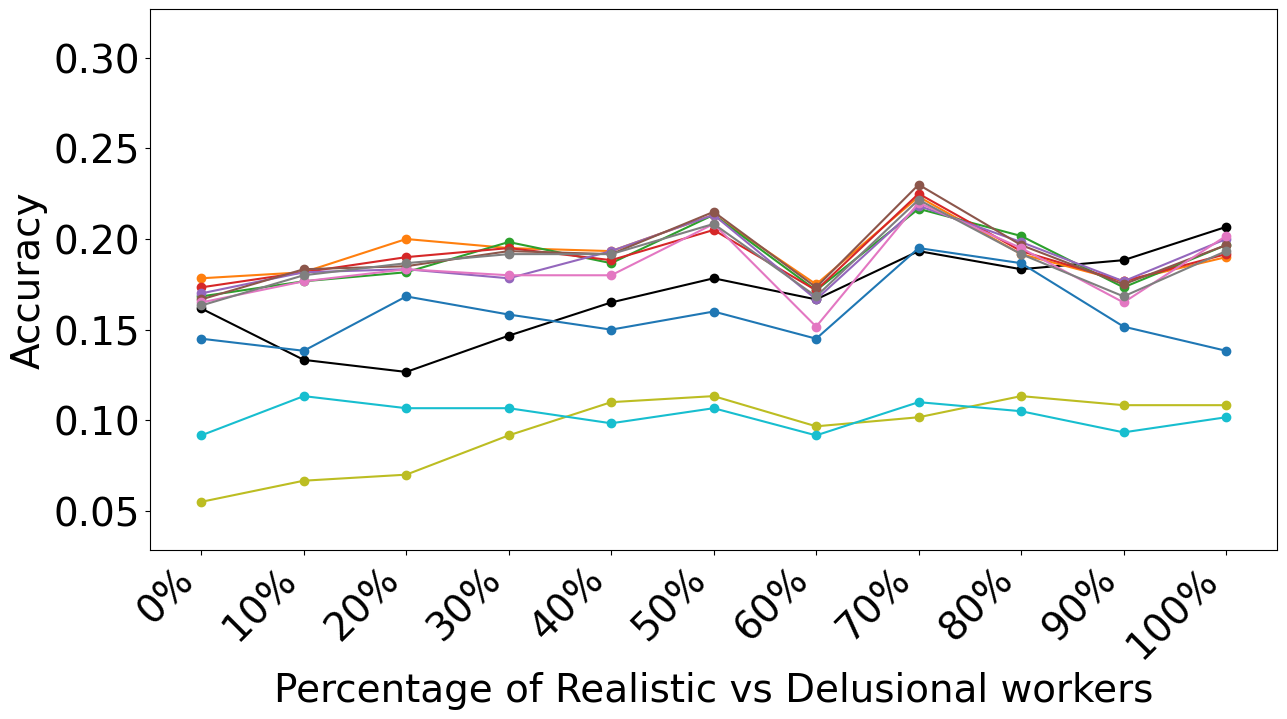

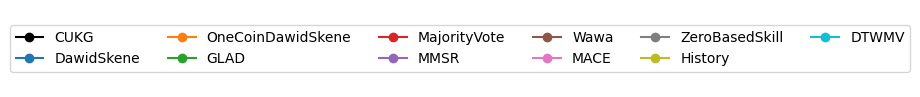

In [38]:
plot_experiment(final_accuracies[0], "Percentage of Realistic vs Delusional workers", "Accuracy", classifiers, fig_name='realistic_vs_delusional_acc', min_y=min_acc, max_y=max_acc, save_file=save_file)

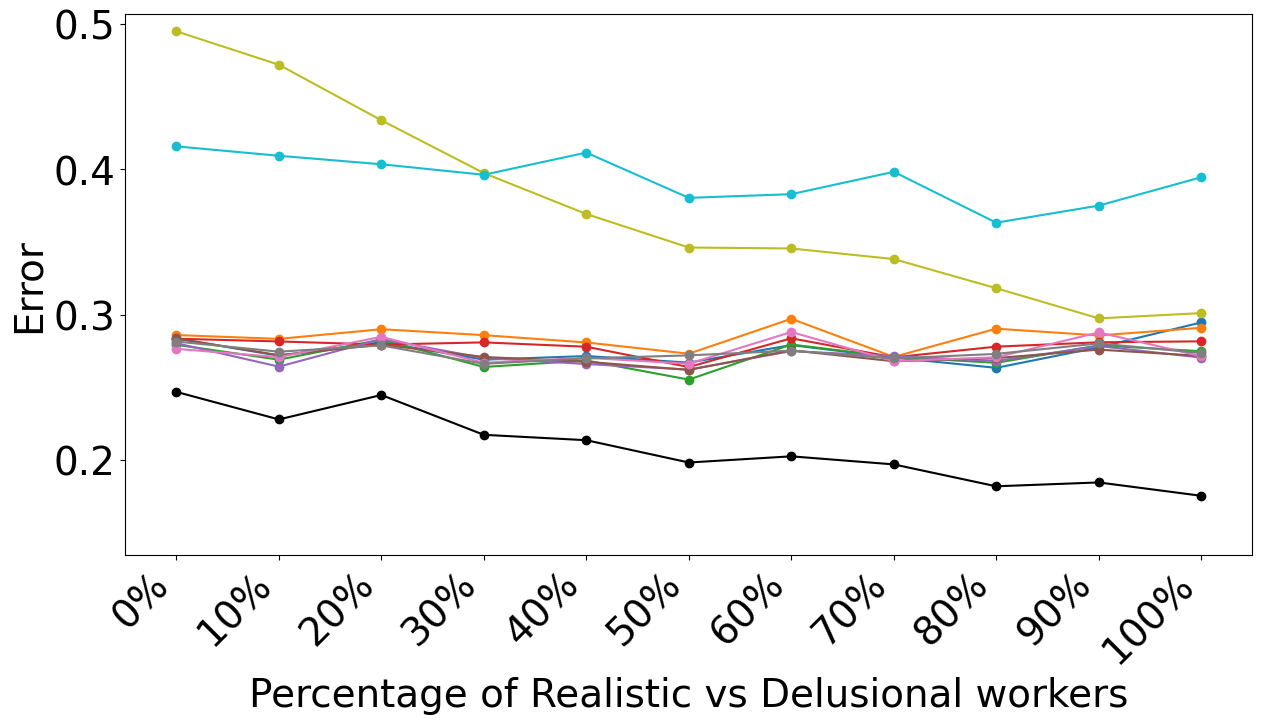

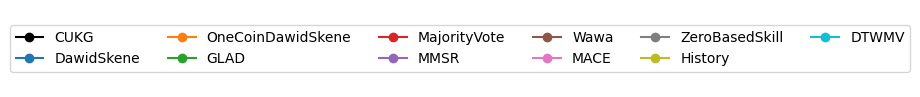

In [39]:
plot_experiment(final_errors[0], "Percentage of Realistic vs Delusional workers", "Error", classifiers, fig_name='realistic_vs_delusional_err', min_y=min_error, max_y=max_error, save_file=save_file)

## Experiment 2: Realistic vs Malicious

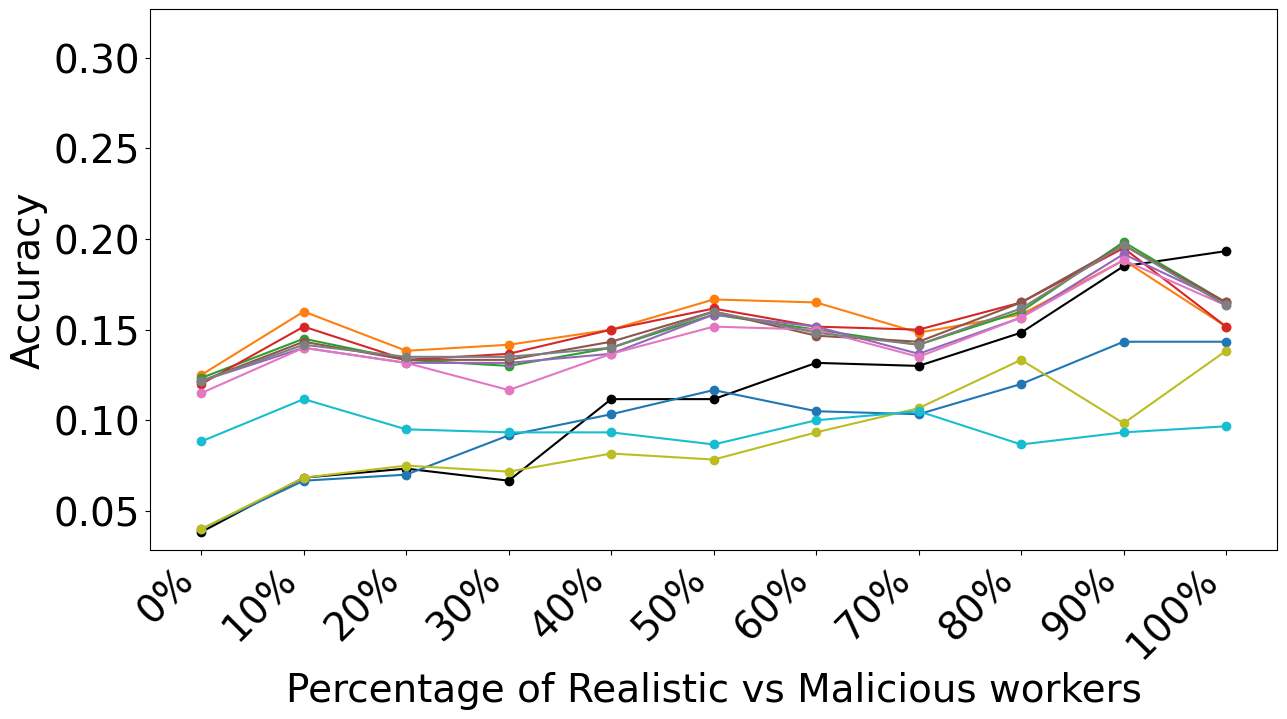

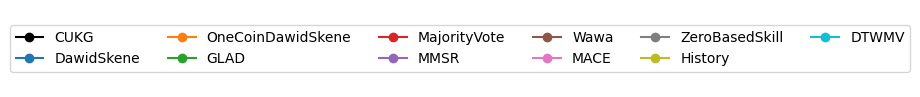

In [40]:
plot_experiment(final_accuracies[1], "Percentage of Realistic vs Malicious workers", "Accuracy", classifiers,fig_name='realistic_vs_malicious_acc', min_y=min_acc, max_y=max_acc, save_file=save_file)

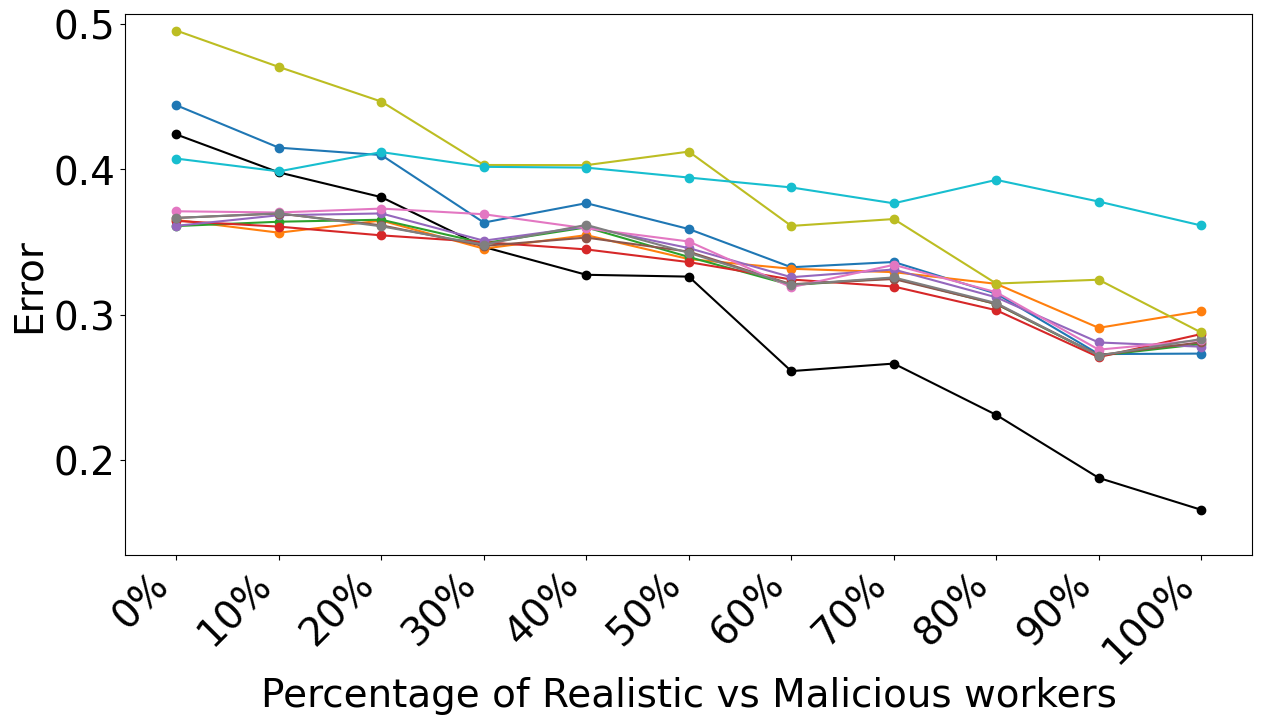

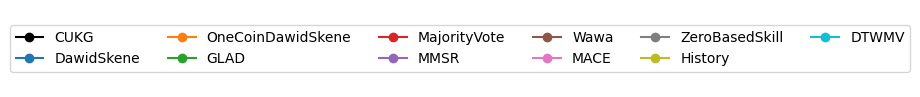

In [41]:
plot_experiment(final_errors[1], "Percentage of Realistic vs Malicious workers", "Error", classifiers,fig_name='realistic_vs_malicious_err', min_y=min_error, max_y=max_error, save_file=save_file)

## Experiment 3: Realistic vs Random

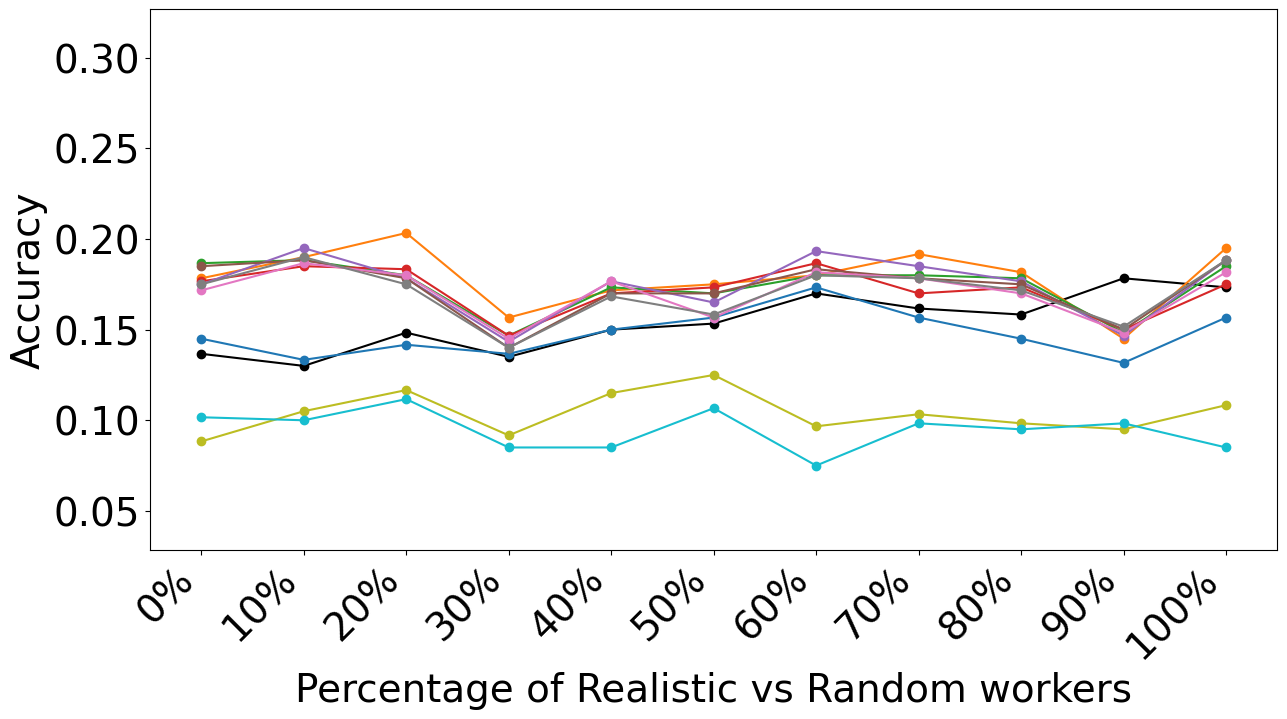

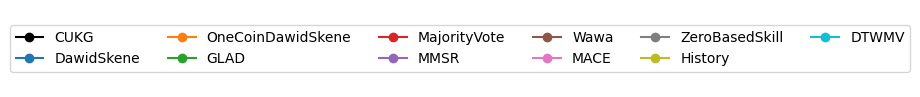

In [42]:
plot_experiment(final_accuracies[2], "Percentage of Realistic vs Random workers", "Accuracy", classifiers,fig_name='realistic_vs_random_acc', min_y=min_acc, max_y=max_acc, save_file=save_file)

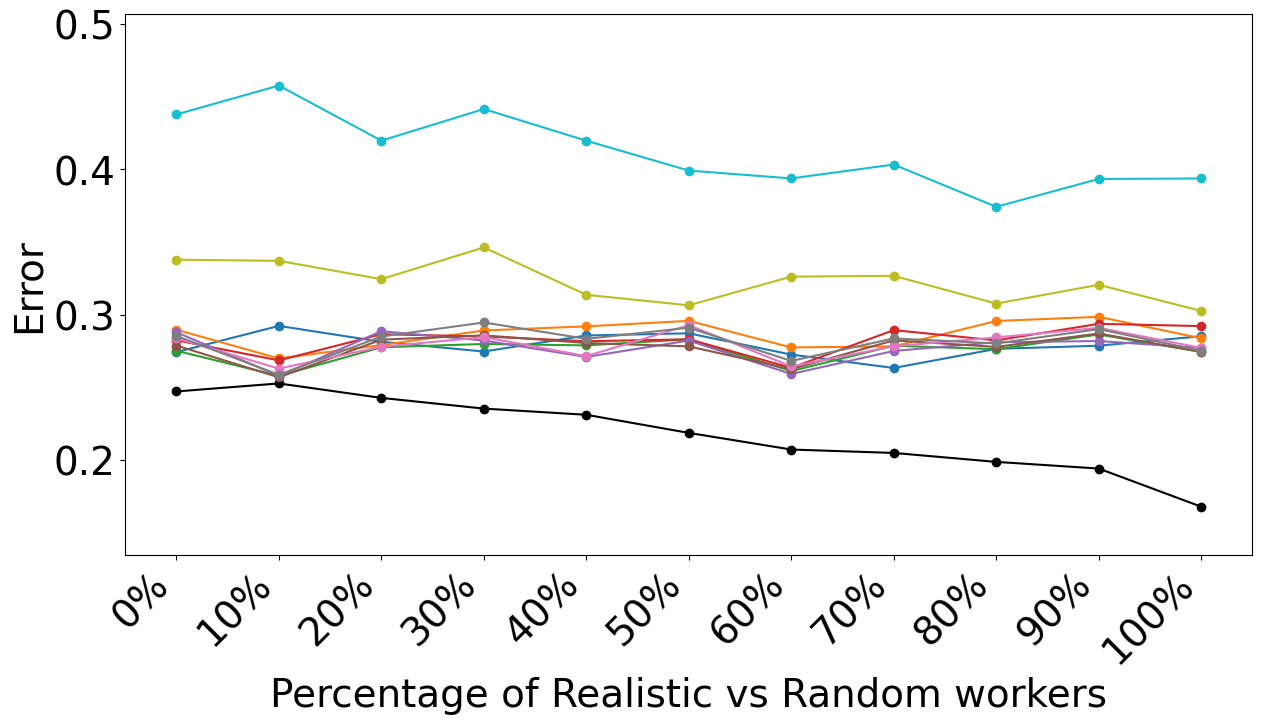

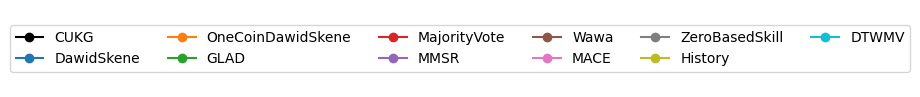

In [43]:
plot_experiment(final_errors[2], "Percentage of Realistic vs Random workers", "Error", classifiers,fig_name='realistic_vs_random_err', min_y=min_error, max_y=max_error, save_file=save_file)

## Experiment 4: Excellent vs Malicious

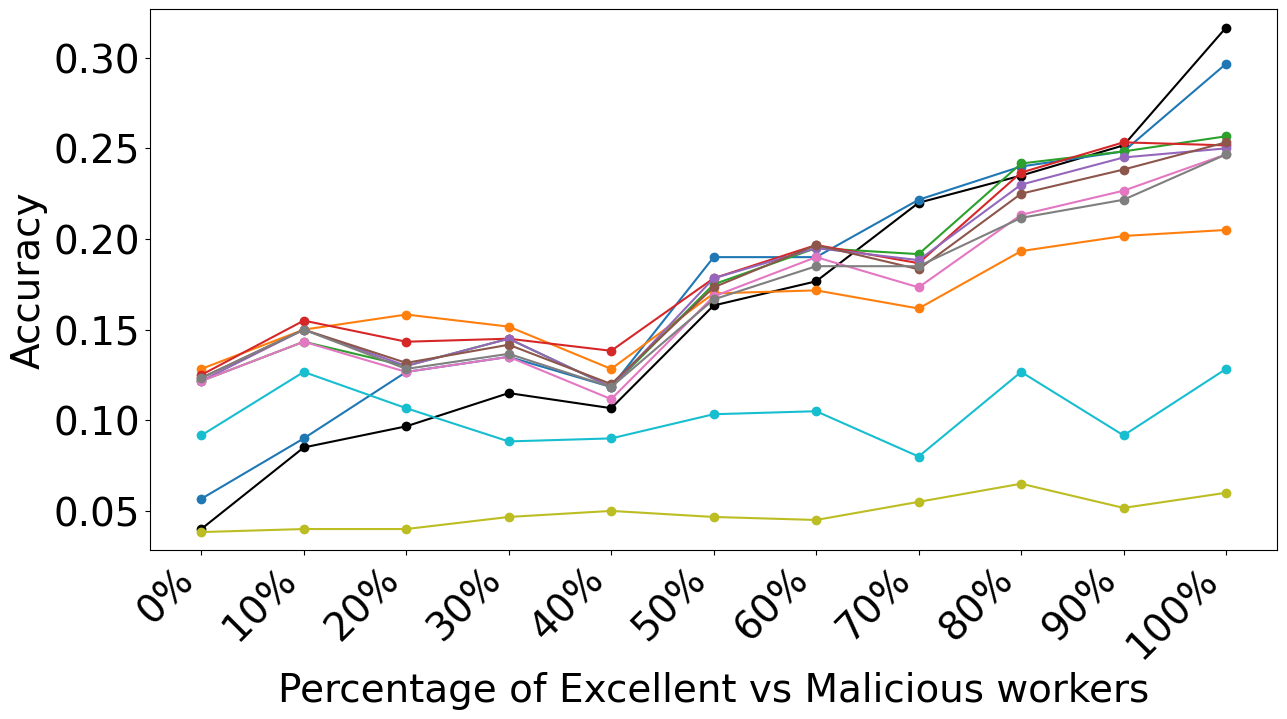

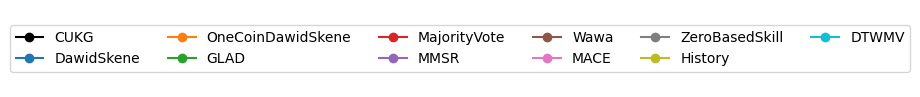

In [44]:
plot_experiment(final_accuracies[3], "Percentage of Excellent vs Malicious workers", "Accuracy", classifiers,fig_name='excellent_vs_malicious_acc', min_y=min_acc, max_y=max_acc, save_file=save_file)

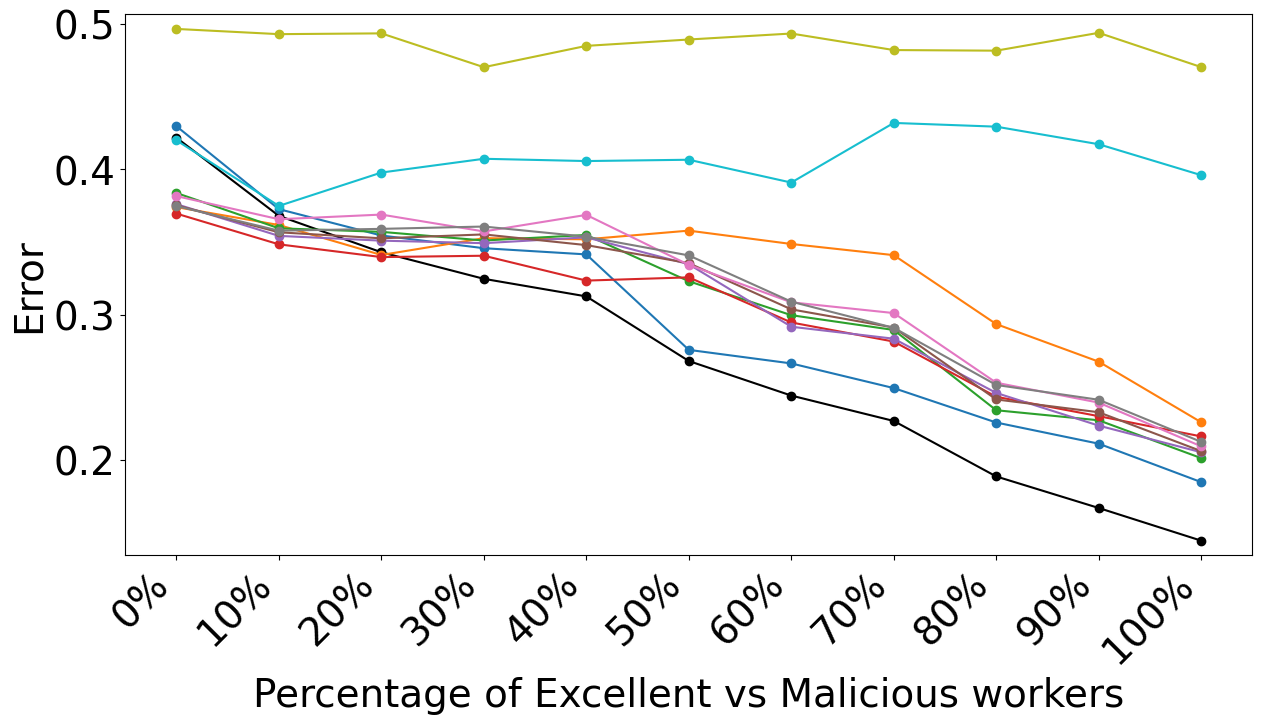

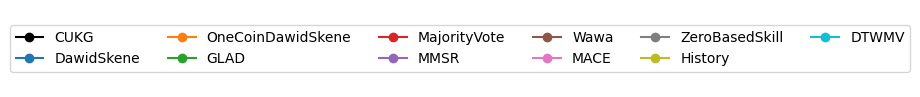

In [45]:
plot_experiment(final_errors[3], "Percentage of Excellent vs Malicious workers", "Error", classifiers,fig_name='excellent_vs_malicious_err', min_y=min_error, max_y=max_error, save_file=save_file)